In [31]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from utils import MSE,Poisson_reg, sample_PLN, sigmoid, logit, log_stirling, build_block_Sigma

import matplotlib.pyplot as plt
from pandas import read_csv
import math 
import time 
plt.style.use('ggplot')

import threading

import numpy as np
import seaborn as sns 
import torch
import scipy.linalg as SLA 
from scipy.linalg import toeplitz 
from sklearn.linear_model import LinearRegression
torch.set_default_dtype(torch.float64)

In [3]:
torch.set_default_dtype(torch.float64)

In [4]:
#get the device. can be used with GPU
if torch.cuda.is_available(): 
    device = torch.device('cuda') 
else : 
    device = torch.device('cpu')
print('device : ', device)

device :  cpu


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


max  -84642.36392068029


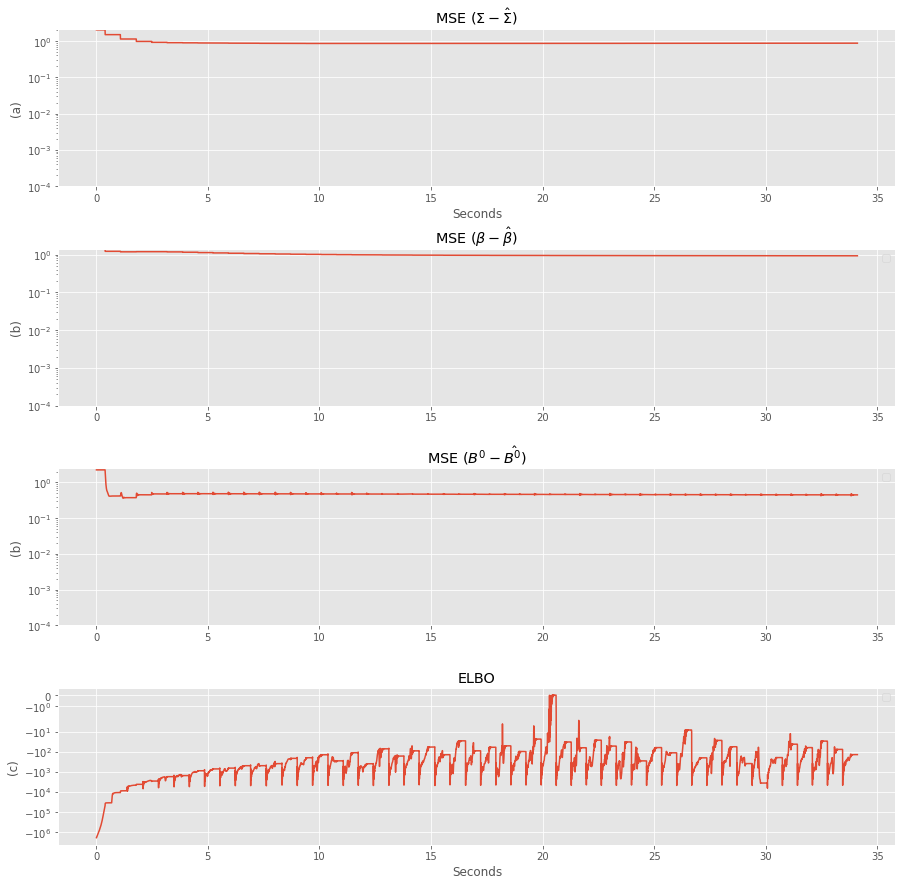

In [170]:
def show(model,name_doss = '' , save = False):
    '''
    function to show one model. It will plot the MSE of Sigma and beta according to the true parameters and 
    the log_likelihood in the y axis with the runtime in the x-axis.Will also plot the norm of the gradients and 
    the variance of the weights used for the importance sampling. 
    
    args : 
        'model' MC_PLNPCA object where you have called model.fit_IMPS()
        'name_doss' : str. the name of the file you want to save the graphic. 
        'save' : bool. If True, the graphic will be saved. If false, won't be saved. 
        
    returns : 
            None but displays the figure. It can also save the figure if save = True. 
    '''
    fig,ax = plt.subplots(4,1,figsize = (15,15))
    
    max_ = np.max(np.array(model.ELBO_list))
    print('max ', max_)
    #MSE of Sigma
    abscisse = model.running_times
    plt.subplots_adjust(hspace = 0.4)
    ax[0].plot(abscisse, model.MSE_Sigma_list)
    ax[0].set_title(r'MSE $(\Sigma- \hat \Sigma)$')
    ax[0].set_xlabel('Seconds')
    ax[0].set_ylim(ymin= 1e-4)
    ax[0].set_ylabel('(a)')
    ax[0].set_yscale('log')
    
    #MSE of beta. 
    ax[1].plot(abscisse, model.MSE_beta_list)
    ax[1].set_title(r'MSE $(\beta - \hat \beta)$') 
    ax[1].set_yscale('log')
    ax[1].set_ylim(ymin= 1e-4)
    ax[1].set_ylabel('(b)')
    ax[1].legend()
    
    ax[2].plot(abscisse, model.MSE_B_zero_list)
    ax[2].set_title(r'MSE $(B^{0} - \hat {B^{0}})$') 
    ax[2].set_yscale('log')
    ax[2].set_ylim(ymin= 1e-4)
    ax[2].set_ylabel('(b)')
    ax[2].legend()
    
    #log likelihood of the model. will also plot the log likelihood of the model with the true parameters. 
    ax[3].plot(abscisse, np.array(model.ELBO_list)-max_)
    ax[3].set_title('ELBO')
    ax[3].set_ylabel('ELBO')
    ax[3].set_xlabel('Seconds')
    #variational_log_like = variational_model.compute_mean_log_likelihood(0.0001)[0].item()
    #ax[2].axhline(variational_log_like, c = 'black', label = 'variaitional likelihood')
    ax[3].set_yscale('symlog')
    ax[3].set_ylabel('(c)')
    ax[3].legend()

    if save : 
        plt.savefig(name_doss)
    plt.show()
    
show(model_VEM)

In [226]:
class ZI_PLN():
    def __init__(self, class_optimizer = torch.optim.Rprop, true_value = False): 
        '''
            Initialization. We only define some useful stuff. The intialization of the
            parameters is done int the init_data() function. 
        '''
        self.old_loss = 1
        
        self.class_optimizer = class_optimizer
        
        self.true_value = true_value
        # some lists to store some stats
        self.t0 = time.time()
        self.MSE_Sigma_list = list()
        self.MSE_beta_list = list()
        self.MSE_B_zero_list = list()
        self.ELBO_list = list()
        self.running_times = list()
        self.cmpt = 0 
        
    def init_data(self,data): 
        '''
        function to extract the data. This function is just here to have a code more compact. We 
        also intialize the parameters.
        
        args : 
              'data': list with 3 elements : Y, O and covariates in this order. 
        '''
        #known variables
        self.Y = data[0].to(device);self.O = data[1].to(device);self.covariates = data[2].to(device)
        self.n, self.p = self.Y.shape
        self.d = self.covariates.shape[1]

        #model parameter 
        noise = torch.randn(self.p)
        self.Sigma =  (torch.diag(noise**2)+ 1e-1).to(device) 
        self.Sigma.requires_grad_(False)#we won't use gradients on Sigma
        self.beta = torch.rand((self.d, self.p)).to(device)
        self.beta.requires_grad_(False)
        self.B_zero = torch.randn((self.d,self.p)).to(device)
        if self.true_value : 
            self.beta = torch.clone(true_beta)
            self.Sigma = torch.clone(true_Sigma)
            #self.B_zero = torch.clone(true_B_zero)
        self.B_zero.requires_grad_(True)
        print('MSE Sigma', MSE(self.Sigma-true_Sigma))
        print('MSE beta', MSE(self.beta - true_beta))
        self.nb_zero = torch.sum(self.Y==0)
        self.dirac = (self.Y==0)
        
        #variational parameter
        self.M = torch.randn((self.n,self.p)).to(device)
        self.M.requires_grad_(True)
        self.S = torch.randn((self.n,self.p)).to(device)
        self.S.requires_grad_(True)
        self.pi = torch.empty(self.n, self.p).uniform_(0, 1).to(device)*self.dirac
        self.pi.requires_grad_(False)
        
        self.params = {'S' : self.S,'M': self.M, 'beta' : self.beta, 
                       'Sigma' : self.Sigma,'pi': self.pi, 
                       'B_zero': self.B_zero}
        
    def compute_ELBO_ZI(self): 
        return ELBO_ZI(self.Y,self.O,self.covariates, self.M, self.S, self.Sigma, self.beta, self.pi, self.B_zero, self.dirac)
    def ZI_grad_M(self): 
        A = torch.exp(self.O+self.M+torch.multiply(self.S,self.S)/2)
        return  torch.multiply(1-self.pi, self.Y-A)-torch.mm((self.M-torch.mm(self.covariates, self.beta)), torch.inverse(self.Sigma))
    def ZI_grad_S(self): 
        A = torch.exp(self.O+self.M+torch.multiply(self.S,self.S)/2)
        first = torch.div(1,self.S)
        sec = torch.multiply(torch.multiply(1-self.pi, self.S), A)
        third = torch.mm(self.S,torch.diag(torch.diag(torch.inverse(self.Sigma))))
        return first - sec - third
    
    def ZI_grad_B_zero(self):
        first =  torch.mm(self.covariates.T, self.pi)
        XB_zero = torch.mm(self.covariates, self.B_zero)
        sec = torch.mm(self.covariates.T, sigmoid(XB_zero))
        return first - sec
    
    def ZI_grad_pi(self,pi_): 
        A = torch.exp(self.O+self.M+torch.multiply(self.S,self.S)/2)
        XB_zero = torch.mm(self.covariates, self.B_zero)
        return (A + XB_zero -logit(pi_))*self.dirac
    
    def fit(self,Y, O, covariates, tolerance ,Niter,lr,  verbose): 
        '''
        gradient ascent function. We compute the gradients thanks to the autodifferentiation of pytorch. 

        args : 
                'optimizer' : torch.optim.optimizer. the optimizer for the parameters. 

                'compute_gain' : function. It should call the parameters by itself. i.e. we will
                                call compute_gain() without any parameter in argument. 

                       
                'tolerance': float. the threshold we set to stop the algorithm. It will 
                              stop  if we are not improving the loss more than tolerance. 
                              
                'N_epoch': int. the Maximum number of epoch we are ready to do. 
                

                'Verbose' : bool. if True, will print some messages useful to 
                            interpret the gradient ascent. If False, nothing will be printed. 
 
        returns : None 
        '''
        data = [Y,O,covariates]
        self.init_data(data)
        
        optimizer = self.class_optimizer([self.S,self.M, self.B_zero], lr = lr)
        
        optimizer.zero_grad()

        stop_condition = False 
        i = 0

        while i < Niter and stop_condition == False: 
            #with torch.no_grad(): 
                
            optimizer.zero_grad()
            loss = -self.compute_ELBO_ZI()
            loss.backward()
            #self.pi.grad = torch.nan_to_num(self.pi.grad, nan = 0, neginf = 0)*self.dirac
            #self.pi.grad*=0
            #closed = self.ZI_grad_pi(closed_pi(self.O,self.M,self.S,self.dirac, self.covariates, self.B_zero))
            
            #print('diff M', torch.norm(self.M.grad + self.ZI_grad_M()))
            #print('diff S', torch.norm(self.S.grad + self.ZI_grad_S()))
            #print('diff B_zero', torch.norm(self.B_zero.grad + self.ZI_grad_B_zero()))
            optimizer.step()
            delta = self.old_loss - loss.item() 
            # condition to see if we have reach the tolerance threshold
            if  abs(delta) < tolerance :
                stop_condition = True 
            
            self.old_loss = loss.item()
            
            with torch.no_grad(): 
                self.Sigma = closed_Sigma(self.M,self.S,self.covariates,self.beta)
                self.beta = closed_beta(self.covariates,self.M)
                self.pi = closed_pi(self.O,self.M,self.S,self.dirac, self.covariates, self.B_zero)
                

            # keep track of the error with Sigma. 
            
            self.MSE_Sigma_list.append(torch.mean((self.Sigma-true_Sigma)**2).item())
            self.MSE_beta_list.append(torch.mean((self.beta-true_beta)**2).item())
            self.MSE_B_zero_list.append(torch.mean((self.B_zero-true_B_zero)**2).item())
            self.ELBO_list.append(-loss.item())
            
            print(' MSE with Sigma : ', np.round(self.MSE_Sigma_list[-1],5))
            print(' MSE with beta : ', np.round(self.MSE_beta_list[-1],5))
            print('MSE with B_zero', np.round(self.MSE_B_zero_list[-1],5))
                
            i += 1
            #keep track of the time 
            self.running_times.append(time.time()-self.t0)

        # print some stats if we want to 
        if verbose : 
            if stop_condition : 
                print('---------------------------------Tolerance {} reached in {} iterations'.format(tolerance, i))
            else : 
                print('---------------------------------Maximum number of iterations reached : ', N_epoch, 'last delta = ', delta)

    def fit_VEM(self,Y, O, covariates, tolerance ,Niter,nb_each_iter, lr,  verbose): 
        self.t0 = time.time()
        data = [Y,O,covariates]
        self.init_data(data)

        for i in range(Niter): 
            self.VE_step(nb_each_iter, 0, 10*lr)
            self.M_step(nb_each_iter, 0, lr)

            
    def VE_step(self, N_iter_max,tolerance, lr): 
        VE_optimizer = self.class_optimizer([self.M,self.S], lr  = lr)
        VE_optimizer.zero_grad()
        with torch.no_grad():
            self.pi = closed_pi(self.O,self.M,self.S,self.dirac, self.covariates, self.B_zero)
        crit = 2*tolerance +1
        i = 0
        self.old_M = torch.clone(self.M)
        self.old_S = torch.clone(self.S)
        while i < N_iter_max and crit > tolerance : 
            loss = -self.compute_ELBO_ZI()
            loss.backward()
            VE_optimizer.step()
            VE_optimizer.zero_grad()
            i += 1
            crit = torch.max((torch.norm(self.M-self.old_M))/torch.norm(self.old_M), torch.norm(self.S-self.old_S)/torch.norm(self.old_S))
#             print('ELBO', -loss.item())
#             print('crit :', crit)
            self.old_M = torch.clone(self.M)
            self.old_S = torch.clone(self.S)
            self.MSE_Sigma_list.append(torch.mean((self.Sigma-true_Sigma)**2).item())
            self.MSE_beta_list.append(torch.mean((self.beta-true_beta)**2).item())
            self.MSE_B_zero_list.append(torch.mean((self.B_zero-true_B_zero)**2).item())
            self.ELBO_list.append(-loss.item())
            self.running_times.append(time.time()-self.t0)
                             
    def M_step(self, N_iter_max,tolerance, lr): 
        M_optimizer = self.class_optimizer([self.B_zero], lr  = lr)
        M_optimizer.zero_grad()
        with torch.no_grad():
            #pass 
            self.beta = closed_beta(self.covariates,self.M)
            self.Sigma = closed_Sigma(self.M,self.S,self.covariates,self.beta)#= closed_pi(self.O,self.M,self.S,self.dirac, self.covariates, self.B_zero)
        crit = 2*tolerance+1 
        i = 0
        self.old_B_zero = torch.clone(self.B_zero)
        while i < N_iter_max and crit > tolerance : 
            loss = -self.compute_ELBO_ZI()
            loss.backward()
            M_optimizer.step()
            M_optimizer.zero_grad()
            i += 1
            crit = (torch.norm(self.B_zero-self.old_B_zero))/torch.norm(self.old_B_zero)
            self.MSE_Sigma_list.append(torch.mean((self.Sigma-true_Sigma)**2).item())
            self.MSE_beta_list.append(torch.mean((self.beta-true_beta)**2).item())
            self.MSE_B_zero_list.append(torch.mean((self.B_zero-true_B_zero)**2).item())
            self.ELBO_list.append(-loss.item())
            self.running_times.append(time.time()-self.t0)
            #             print('crit :', crit)
            self.old_B_zero = torch.clone(self.B_zero)
        print(' MSE with Sigma : ', np.round(MSE(self.Sigma-true_Sigma),5))
        print('B_zero', self.B_zero)
        print(' MSE with beta : ', np.round(MSE(self.beta - true_beta),5))
        print('MSE with B_zero', np.round(MSE(self.B_zero -true_B_zero ).item(),5))

        

In [240]:
def ELBO_ZI(Y,O,covariates, M, S, Sigma, beta, pi, B_zero, dirac): 
    if torch.norm(pi*dirac - pi) > 0.0001: 
        print('Bug')
        return False
    
    n = Y.shape[0]
    SrondS = torch.multiply(S,S)
    OplusM = O+M
    MmoinsXB = M-torch.mm(covariates, beta) 
    XB_zero = torch.mm(covariates, B_zero)
    #tmp =  0 
    tmp  = torch.sum(torch.multiply(1-pi,torch.multiply(Y, OplusM)  -torch.exp(OplusM+SrondS/2)-log_stirling(Y))  +1/2*torch.log(SrondS))
    tmp += torch.sum(torch.multiply(pi,XB_zero))
    #tmp -= torch.sum(torch.multiply(pi,logit(pi)))
    tmp -= torch.sum(torch.log(1+ torch.exp(XB_zero)))
    #tmp -= torch.sum(torch.log(1-pi))
    tmp -= 1/2*torch.trace(  
                            torch.mm(  
                                        torch.inverse(Sigma), 
                                        torch.diag(torch.sum(SrondS, dim = 0))+ torch.mm(MmoinsXB.T, MmoinsXB)
                                    )
                          )
    tmp-= n/2*torch.log(torch.det(Sigma))
    return tmp

def closed_Sigma(M,S,covariates,beta):
    '''
    closed form for Sigma with the first parametrisation centered in X\beta and variance Sigma 
    '''
    n,p = M.shape
    MmoinsXB = M-torch.mm(covariates,beta)
    return 1/(n)*(torch.mm(MmoinsXB.T,MmoinsXB) + torch.diag(torch.sum(torch.multiply(S,S), dim = 0)))

def closed_beta(X,M): # the X is the covariates. 
    '''
    closed form for beta with the first parametrisation above
    '''
    return torch.mm(torch.mm(torch.inverse(torch.mm(X.T,X)), X.T),M)

def closed_pi(O,M,S,dirac, covariates, B_zero): 
    '''
    closed form for pi with the parametrisation centered in Xbeta and variance Sigma
    '''
    A = torch.exp(O+M+torch.multiply(S,S)/2)
    pi_chap = torch.multiply(sigmoid(A+torch.mm(covariates, B_zero)), dirac)
    return pi_chap

In [241]:
model_VEM = ZI_PLN(true_value = False, class_optimizer = torch.optim.Rprop)
model_VEM.fit_VEM(Y_sampled, O, covariates, tolerance = 0 ,Niter = 200,nb_each_iter= 5, lr = 0.01,  verbose = False)

MSE Sigma tensor(2.0012)
MSE beta tensor(1.4729)
 MSE with Sigma :  tensor(1.8822)
B_zero tensor([[ 0.5107, -0.4668, -0.2183, -0.3656,  0.2276,  0.1346,  0.0952, -0.2951,
          1.4976, -0.5899,  0.3569, -0.2454,  0.7492, -2.3520,  1.6446, -0.3605,
          1.2418, -0.8440, -1.8215,  0.4558],
        [ 0.9248, -0.1816,  1.0525, -0.5264, -0.4368, -0.8932,  0.4116, -0.8853,
          0.6190, -0.2029, -0.3621,  1.0927,  0.8583,  0.4189,  1.7852,  1.2018,
         -0.8606,  0.7972, -1.2173,  0.4338]], requires_grad=True)
 MSE with beta :  tensor(1.1082)
MSE with B_zero 1.55431
 MSE with Sigma :  tensor(1.9014)
B_zero tensor([[ 0.4363, -0.5412, -0.1439, -0.2912,  0.3021,  0.0602,  0.1696, -0.2207,
          1.5328, -0.5155,  0.2825, -0.2746,  0.6748, -2.2776,  1.5702, -0.2860,
          1.1673, -0.9184, -1.7471,  0.3813],
        [ 0.9785, -0.2560,  1.1269, -0.4520, -0.3624, -0.9676,  0.4860, -0.8109,
          0.5446, -0.1285, -0.3539,  1.0183,  0.7839,  0.4933,  1.7560,  1.2555,
     

 MSE with Sigma :  tensor(1.9762)
B_zero tensor([[ 0.1571, -1.5830,  0.8979, -0.7106,  0.9158, -0.5235,  1.2114,  0.8211,
          2.2845,  0.5264, -0.3693,  0.2650, -0.3011, -1.2358,  0.9480,  0.7558,
          0.1255, -1.9603, -0.7053,  0.6617],
        [ 1.2670,  0.0042,  1.1019,  0.3312, -1.0562, -1.5036,  1.5278,  0.2309,
         -0.1040,  0.9133, -0.0306,  0.4111, -0.2579,  1.5351,  2.5057,  0.5777,
         -0.0947, -0.3191, -0.3977, -0.1865]], requires_grad=True)
 MSE with beta :  tensor(0.8526)
MSE with B_zero 0.6988
 MSE with Sigma :  tensor(1.9740)
B_zero tensor([[ 0.1483, -1.6574,  0.9724, -0.7398,  0.9240, -0.5527,  1.2858,  0.8955,
          2.2835,  0.6008, -0.3985,  0.2725, -0.3099, -1.1613,  0.9398,  0.8302,
          0.0511, -2.0347, -0.6516,  0.6542],
        [ 1.2582,  0.0124,  1.0583,  0.3394, -1.0998, -1.5572,  1.6022,  0.3053,
         -0.1050,  0.9877, -0.0224,  0.4101, -0.3323,  1.6095,  2.5132,  0.5033,
         -0.0410, -0.3935, -0.4721, -0.1940]], requires

 MSE with Sigma :  tensor(1.6466)
B_zero tensor([[ 0.2811, -2.7737,  1.5618, -1.1891,  0.9698, -0.8561,  2.4021,  1.6877,
          2.2704,  1.0356, -0.3958,  0.4294,  0.0235, -0.0451,  0.8733,  1.2474,
         -0.3251, -3.1509, -0.5596,  0.6895],
        [ 1.0041,  0.5820,  0.6483,  0.8150, -1.4442, -2.6320,  1.9664,  0.5457,
          0.1413,  2.1040,  0.2819,  0.6932, -0.3164,  2.1558,  2.4922,  0.2918,
          0.1548, -1.5097, -1.0587,  0.0946]], requires_grad=True)
 MSE with beta :  tensor(0.6746)
MSE with B_zero 0.67825
 MSE with Sigma :  tensor(1.6104)
B_zero tensor([[ 0.2893, -2.8481,  1.5608, -1.1973,  0.9610, -0.9097,  2.4765,  1.7037,
          2.2622,  1.0274, -0.3666,  0.4382,  0.0527,  0.0293,  0.8743,  1.2392,
         -0.3241, -3.2253, -0.5684,  0.6813],
        [ 0.9966,  0.6172,  0.6558,  0.8310, -1.4602, -2.7064,  1.9312,  0.5545,
          0.1705,  2.1577,  0.3111,  0.7020, -0.2872,  2.1476,  2.4932,  0.3078,
          0.1558, -1.5841, -1.1124,  0.1238]], require

 MSE with Sigma :  tensor(1.1090)
B_zero tensor([[ 0.4577, -3.9643,  1.5026, -1.2555,  0.8290, -2.0052,  2.8309,  1.8070,
          2.2223,  1.0019, -0.0942,  0.5533,  0.2890,  0.8149,  0.9123,  1.1466,
         -0.3516, -4.3416, -0.5984,  0.6630],
        [ 0.7135,  1.0646,  0.7343,  1.0172, -1.9853, -3.8227,  1.7450,  0.7003,
          0.3627,  2.4068,  0.5215,  0.7121, -0.1384,  1.7181,  2.4992,  0.4628,
          0.1538, -2.7004, -2.1664,  0.2980]], requires_grad=True)
 MSE with beta :  tensor(0.7144)
MSE with B_zero 1.10472
 MSE with Sigma :  tensor(1.0837)
B_zero tensor([[ 0.4659, -4.0388,  1.5016, -1.2565,  0.8202, -2.0797,  2.8334,  1.8060,
          2.2298,  1.0009, -0.0782,  0.5523,  0.3050,  0.8224,  0.9113,  1.1456,
         -0.3506, -4.4160, -0.5902,  0.6620],
        [ 0.6855,  1.0928,  0.7333,  1.0162, -2.0390, -3.8971,  1.7460,  0.6993,
          0.3702,  2.4143,  0.5205,  0.7111, -0.1466,  1.7099,  2.4982,  0.4618,
          0.1548, -2.7748, -2.2408,  0.3055]], require

 MSE with Sigma :  tensor(0.8251)
B_zero tensor([[ 0.5019, -5.1550,  1.4526, -1.2895,  0.6270, -2.9984,  2.8494,  1.8265,
          2.2488,  0.9715,  0.0173,  0.5763,  0.3810,  0.9944,  0.9248,  1.0871,
         -0.3866, -5.5322, -0.4812,  0.6270],
        [ 0.3879,  1.3838,  0.7298,  1.0222, -3.0478, -5.0133,  1.7335,  0.7283,
          0.3727,  2.5013,  0.4796,  0.7096, -0.1658,  1.5973,  2.5012,  0.4843,
          0.0593, -2.7821, -3.3571,  0.3330]], requires_grad=True)
 MSE with beta :  tensor(0.7473)
MSE with B_zero 1.86707
 MSE with Sigma :  tensor(0.8144)
B_zero tensor([[ 0.5029, -5.2294,  1.4536, -1.2885,  0.5978, -3.0072,  2.8582,  1.8275,
          2.2478,  0.9705,  0.0163,  0.5773,  0.3820,  0.9934,  0.9173,  1.0796,
         -0.3941, -5.6067, -0.4530,  0.6260],
        [ 0.3719,  1.4190,  0.7308,  1.0232, -3.0770, -5.0877,  1.7210,  0.7293,
          0.3717,  2.5003,  0.4786,  0.7106, -0.1648,  1.5963,  2.4937,  0.4853,
          0.0518, -2.7539, -3.4315,  0.3320]], require

 MSE with Sigma :  tensor(0.7155)
B_zero tensor([[ 0.4899, -6.0336,  1.4091, -1.3330,  0.3422, -2.8240,  2.8700,  1.8425,
          2.2723,  0.9555,  0.0108,  0.5548,  0.3685,  1.0379,  0.8898,  0.9841,
         -0.4726, -6.0624, -0.3116,  0.6015],
        [ 0.0611,  1.6476,  0.7118,  1.0127, -3.6122, -6.2040,  1.6945,  0.7103,
          0.3707,  2.5278,  0.4731,  0.7151, -0.1868,  1.5341,  2.4877,  0.4918,
         -0.0862, -2.6813, -3.9405,  0.3480]], requires_grad=True)
 MSE with beta :  tensor(0.7073)
MSE with B_zero 2.44337
 MSE with Sigma :  tensor(0.7117)
B_zero tensor([[ 0.4811, -6.0411,  1.4101, -1.3405,  0.3262, -2.7958,  2.8690,  1.8435,
          2.2733,  0.9545,  0.0098,  0.5558,  0.3675,  1.0369,  0.8908,  0.9851,
         -0.4716, -6.0784, -0.3106,  0.6025],
        [ 0.0451,  1.6486,  0.7128,  1.0137, -3.6282, -6.2784,  1.6935,  0.7113,
          0.3717,  2.5353,  0.4721,  0.7161, -0.1793,  1.5331,  2.4887,  0.4928,
         -0.1022, -2.6803, -3.9480,  0.3490]], require

 MSE with Sigma :  tensor(0.6784)
B_zero tensor([[ 4.3466e-01, -6.1471e+00,  1.3806e+00, -1.3870e+00,  1.1817e-01,
         -2.5359e+00,  2.8730e+00,  1.8480e+00,  2.2743e+00,  9.5398e-01,
         -3.1953e-03,  5.4027e-01,  3.5148e-01,  1.0579e+00,  8.6979e-01,
          9.1306e-01, -5.5210e-01, -6.1759e+00, -2.9760e-01,  5.8447e-01],
        [-2.1574e-01,  1.6531e+00,  7.0026e-01,  1.0267e+00, -3.7930e+00,
         -7.2458e+00,  1.6805e+00,  6.9880e-01,  3.5568e-01,  2.5518e+00,
          4.6761e-01,  7.0906e-01, -1.8532e-01,  1.4913e+00,  2.4807e+00,
          4.9726e-01, -2.0820e-01, -2.6928e+00, -4.0455e+00,  3.3947e-01]],
       requires_grad=True)
 MSE with beta :  tensor(0.6743)
MSE with B_zero 2.76427
 MSE with Sigma :  tensor(0.6765)
B_zero tensor([[ 4.2586e-01, -6.1461e+00,  1.3816e+00, -1.3860e+00,  1.0217e-01,
         -2.5184e+00,  2.8720e+00,  1.8490e+00,  2.2733e+00,  9.5498e-01,
         -4.1953e-03,  5.3927e-01,  3.5048e-01,  1.0569e+00,  8.7079e-01,
          9.0556e

 MSE with Sigma :  tensor(0.6605)
B_zero tensor([[ 3.6246e-01, -6.1756e+00,  1.3606e+00, -1.4325e+00, -9.8625e-02,
         -2.3404e+00,  2.8858e+00,  1.8505e+00,  2.2833e+00,  9.4948e-01,
         -4.6953e-03,  5.2627e-01,  3.3398e-01,  1.0824e+00,  8.4979e-01,
          8.4206e-01, -6.2310e-01, -6.2299e+00, -2.9210e-01,  5.7047e-01],
        [-6.0054e-01,  1.6586e+00,  6.9726e-01,  1.0522e+00, -3.7868e+00,
         -7.9752e+00,  1.6550e+00,  6.8430e-01,  3.6468e-01,  2.5558e+00,
          4.7461e-01,  7.1206e-01, -1.7582e-01,  1.4638e+00,  2.4777e+00,
          5.1126e-01, -3.3020e-01, -2.6958e+00, -4.0910e+00,  3.5097e-01]],
       requires_grad=True)
 MSE with beta :  tensor(0.6502)
MSE with B_zero 2.99123
 MSE with Sigma :  tensor(0.6594)
B_zero tensor([[ 3.5366e-01, -6.1831e+00,  1.3616e+00, -1.4315e+00, -1.1463e-01,
         -2.3394e+00,  2.8848e+00,  1.8495e+00,  2.2843e+00,  9.5048e-01,
         -3.6953e-03,  5.2527e-01,  3.3298e-01,  1.0834e+00,  8.5079e-01,
          8.4306e

 MSE with Sigma :  tensor(0.6477)
B_zero tensor([[ 0.2217, -6.1851,  1.3511, -1.4505, -0.2552, -2.3244,  2.8868,  1.8565,
          2.2813,  0.9485, -0.0167,  0.5248,  0.3265,  1.0894,  0.8403,  0.7816,
         -0.6836, -6.2564, -0.2931,  0.5650],
        [-1.1973,  1.6576,  0.6963,  1.0512, -3.7989, -8.0102,  1.6318,  0.6903,
          0.3542,  2.5633,  0.4626,  0.7276, -0.1663,  1.4338,  2.4742,  0.5188,
         -0.4927, -2.6968, -4.0835,  0.3625]], requires_grad=True)
 MSE with beta :  tensor(0.6313)
MSE with B_zero 2.99378
 MSE with Sigma :  tensor(0.6470)
B_zero tensor([[ 0.2129, -6.1926,  1.3521, -1.4495, -0.2627, -2.3234,  2.8943,  1.8575,
          2.2803,  0.9495, -0.0177,  0.5258,  0.3275,  1.0904,  0.8413,  0.7826,
         -0.6911, -6.2554, -0.2921,  0.5660],
        [-1.2510,  1.6501,  0.6973,  1.0522, -3.7979, -8.0092,  1.6308,  0.6913,
          0.3532,  2.5643,  0.4616,  0.7201, -0.1653,  1.4348,  2.4732,  0.5198,
         -0.5002, -2.6958, -4.0825,  0.3635]], require

 MSE with Sigma :  tensor(0.6376)
B_zero tensor([[-0.1639, -6.1861,  1.3246, -1.4585, -0.3582, -2.3254,  2.9048,  1.8640,
          2.2903,  0.9490, -0.0227,  0.5098,  0.3225,  1.1054,  0.8298,  0.7466,
         -0.7369, -6.2659, -0.2941,  0.5690],
        [-1.8604,  1.6566,  0.6953,  1.0562, -3.7914, -8.0282,  1.6158,  0.6808,
          0.3632,  2.5638,  0.4651,  0.7211, -0.1618,  1.4158,  2.4845,  0.5263,
         -0.6297, -2.6978, -4.0845,  0.3665]], requires_grad=True)
 MSE with beta :  tensor(0.6217)
MSE with B_zero 3.00882
 MSE with Sigma :  tensor(0.6372)
B_zero tensor([[-0.1931, -6.1851,  1.3171, -1.4660, -0.3657, -2.3244,  2.9038,  1.8650,
          2.2828,  0.9500, -0.0237,  0.5088,  0.3235,  1.1064,  0.8308,  0.7476,
         -0.7359, -6.2734, -0.2931,  0.5700],
        [-1.9141,  1.6491,  0.6963,  1.0572, -3.7904, -8.0272,  1.6148,  0.6818,
          0.3557,  2.5648,  0.4641,  0.7201, -0.1608,  1.4168,  2.4855,  0.5273,
         -0.6372, -2.6968, -4.0835,  0.3675]], require

 MSE with Sigma :  tensor(0.6317)
B_zero tensor([[-0.6311, -6.1871,  1.3116, -1.4715, -0.4272, -2.3264,  2.9228,  1.8550,
          2.2863,  0.9490, -0.0147,  0.5123,  0.3095,  1.1044,  0.8118,  0.7116,
         -0.7634, -6.2839, -0.2866,  0.5590],
        [-2.7193,  1.6471,  0.6963,  1.0632, -3.7754, -8.0207,  1.5998,  0.6718,
          0.3592,  2.5723,  0.4731,  0.7151, -0.1663,  1.4063,  2.4680,  0.5338,
         -0.7497, -2.6988, -4.0770,  0.3650]], requires_grad=True)
 MSE with beta :  tensor(0.6205)
MSE with B_zero 3.05898
 MSE with Sigma :  tensor(0.6313)
B_zero tensor([[-0.6603, -6.1861,  1.3126, -1.4705, -0.4262, -2.3254,  2.9218,  1.8625,
          2.2873,  0.9500, -0.0222,  0.5113,  0.3085,  1.1054,  0.8128,  0.7126,
         -0.7709, -6.2829, -0.2941,  0.5600],
        [-2.7729,  1.6481,  0.6973,  1.0642, -3.7744, -8.0282,  1.5988,  0.6708,
          0.3602,  2.5733,  0.4741,  0.7226, -0.1673,  1.4073,  2.4670,  0.5348,
         -0.7572, -2.6978, -4.0845,  0.3660]], require

 MSE with Sigma :  tensor(0.6273)
B_zero tensor([[-0.9963, -6.1881,  1.3021, -1.4875, -0.4962, -2.3274,  2.9408,  1.8675,
          2.2818,  0.9385, -0.0192,  0.5063,  0.3120,  1.1094,  0.7938,  0.6901,
         -0.7729, -6.2849, -0.2876,  0.5585],
        [-3.4068,  1.6461,  0.7018,  1.0552, -3.7594, -8.0302,  1.5838,  0.6843,
          0.3547,  2.5703,  0.4686,  0.7176, -0.1723,  1.3848,  2.4630,  0.5408,
         -0.8697, -2.6913, -4.0780,  0.3560]], requires_grad=True)
 MSE with beta :  tensor(0.6206)
MSE with B_zero 3.1376
 MSE with Sigma :  tensor(0.6271)
B_zero tensor([[-1.0051, -6.1871,  1.2946, -1.4885, -0.4952, -2.3264,  2.9483,  1.8600,
          2.2808,  0.9375, -0.0182,  0.5138,  0.3110,  1.1104,  0.7948,  0.6911,
         -0.7719, -6.2924, -0.2866,  0.5575],
        [-3.4605,  1.6471,  0.6943,  1.0542, -3.7584, -8.0292,  1.5828,  0.6768,
          0.3537,  2.5693,  0.4696,  0.7251, -0.1733,  1.3858,  2.4640,  0.5418,
         -0.8772, -2.6988, -4.0770,  0.3550]], requires

 MSE with Sigma :  tensor(0.6236)
B_zero tensor([[-1.1371, -6.1806,  1.2926, -1.5035, -0.5482, -2.3284,  2.9643,  1.8620,
          2.2838,  0.9395, -0.0287,  0.5103,  0.3205,  1.1144,  0.7928,  0.6721,
         -0.7909, -6.2944, -0.2886,  0.5570],
        [-4.0062,  1.6451,  0.7073,  1.0647, -3.7434, -8.0397,  1.5818,  0.6703,
          0.3652,  2.5713,  0.4676,  0.7216, -0.1638,  1.3838,  2.4620,  0.5398,
         -0.9642, -2.6923, -4.0790,  0.3715]], requires_grad=True)
 MSE with beta :  tensor(0.6202)
MSE with B_zero 3.22789
 MSE with Sigma :  tensor(0.6235)
B_zero tensor([[-1.1531, -6.1881,  1.2936, -1.5045, -0.5557, -2.3274,  2.9653,  1.8610,
          2.2848,  0.9385, -0.0297,  0.5093,  0.3215,  1.1154,  0.7938,  0.6731,
         -0.7899, -6.2934, -0.2876,  0.5580],
        [-4.0222,  1.6461,  0.7083,  1.0637, -3.7424, -8.0387,  1.5828,  0.6693,
          0.3662,  2.5703,  0.4666,  0.7206, -0.1628,  1.3848,  2.4630,  0.5408,
         -0.9717, -2.6913, -4.0780,  0.3725]], require

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


max  -476341.95209256874


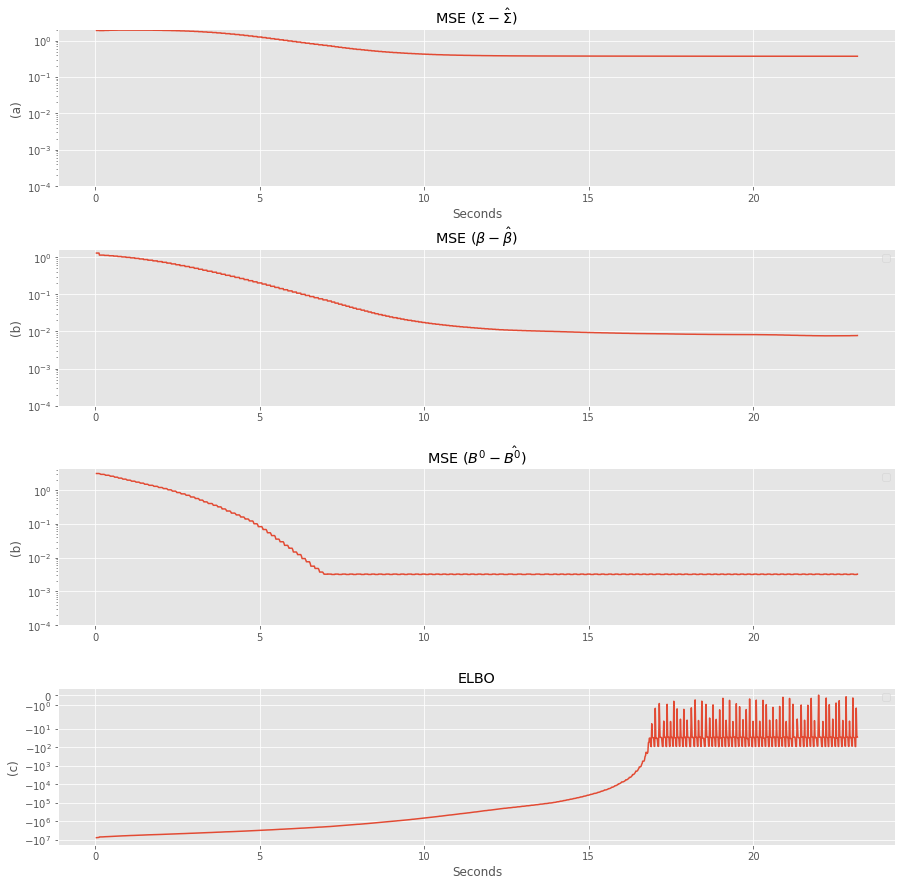

In [239]:
show(model_VEM)

<AxesSubplot:>

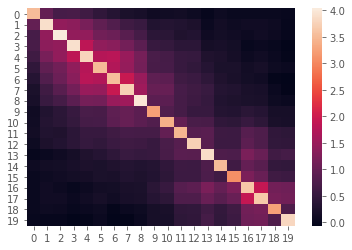

In [233]:
sns.heatmap(model_VEM.Sigma)

In [28]:
model = ZI_PLN(true_value = False)
model.fit(Y_sampled, O, covariates, tolerance = 0  ,Niter = 100,lr = 0.1,  verbose = False)

MSE Sigma tensor(2.0759)
MSE beta tensor(1.7919)
 MSE with Sigma :  1.50076
 MSE with beta :  1.42738
MSE with B_zero 2.06753
 MSE with Sigma :  1.94133
 MSE with beta :  1.39969
MSE with B_zero 2.03352
 MSE with Sigma :  1.97279
 MSE with beta :  1.36707
MSE with B_zero 2.03072
 MSE with Sigma :  1.99511
 MSE with beta :  1.3298
MSE with B_zero 2.0821
 MSE with Sigma :  2.00165
 MSE with beta :  1.27952
MSE with B_zero 2.22259
 MSE with Sigma :  1.9919
 MSE with beta :  1.22376
MSE with B_zero 2.50469
 MSE with Sigma :  1.97128
 MSE with beta :  1.16392
MSE with B_zero 3.00668
 MSE with Sigma :  1.92379
 MSE with beta :  1.10976
MSE with B_zero 3.84445
 MSE with Sigma :  1.83299
 MSE with beta :  1.07029
MSE with B_zero 5.18872
 MSE with Sigma :  1.70027
 MSE with beta :  1.05231
MSE with B_zero 7.28995
 MSE with Sigma :  1.54412
 MSE with beta :  1.04121
MSE with B_zero 10.51427
 MSE with Sigma :  1.38426
 MSE with beta :  1.03728
MSE with B_zero 15.39558
 MSE with Sigma :  1.24812
 

<AxesSubplot:>

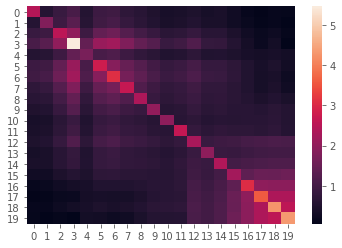

In [81]:
sns.heatmap(model_VEM.Sigma)

<AxesSubplot:>

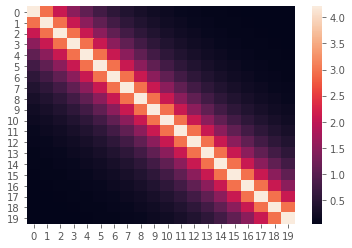

In [83]:
sns.heatmap(true_Sigma)

In [196]:
model.B_zero

tensor([[ -5.3511,  -3.7685,  -3.2715, -14.7825,  -4.0393,   0.3155,   1.1753,
           3.4174,   0.6762,   0.2987,  -2.9239,   1.9175,   2.7192,   1.2105,
           1.9645,   2.7308,   1.3227,  -1.0557,   1.9711,  -1.8590],
        [  0.1055,  -6.5025,   0.6494,   4.7064,  -5.7597,  -3.2761,   1.1872,
         -75.6816,   2.0276,   1.4699,  -1.5330,  -3.6044,   1.8258,   1.3804,
           1.5238,  -2.7404,  -0.2385,   2.0983,  -0.1638,   1.5668]],
       requires_grad=True)

In [71]:
model_VEM.n

2000

In [235]:
d = 2 # nb of cavariates
n = 10000; p = 20

In [236]:
#torch.manual_seed(0)
#true_Sigma = torch.from_numpy(toeplitz(0.6**np.arange(p)))
true_Sigma = torch.from_numpy(build_block_Sigma(p,20)).to(device)
true_C = torch.cholesky(true_Sigma)
true_beta = torch.randn(d, p).to(device)

covariates = torch.rand((n,d))/1
O = 0+torch.zeros((n,p))
true_B_zero = torch.randn((d,p)).to(device)
sample_model = sample_PLN(ZI = True)
Y_sampled, Z_sampled, ksi  = sample_model.sample(true_Sigma.to(torch.device('cpu')),true_beta.to(torch.device('cpu')), O, covariates, true_B_zero)
try : 
    ksi = torch.from_numpy(ksi)
except : 
    pass

Y_sampled = torch.from_numpy(Y_sampled)
data = [Y_sampled.double(), O, covariates]

In [237]:
torch.sum(Y_sampled == 0)/(n*p)

tensor(0.6929)

<AxesSubplot:>

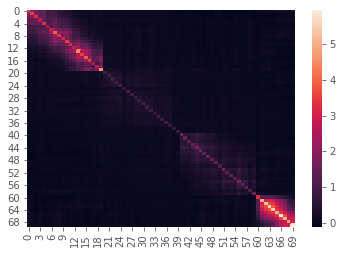

In [155]:
sns.heatmap(model.Sigma)

<AxesSubplot:>

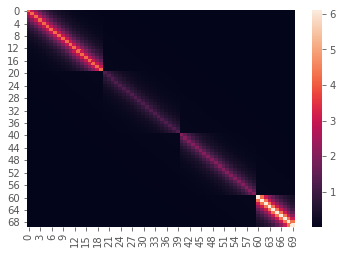

In [153]:
sns.heatmap(true_Sigma)

In [37]:
XB_zero = torch.mm(covariates, true_B_zero)

In [40]:
def log_p_ksi(B_zer): 
    XB_zer = torch.mm(covariates, B_zer)
    return torch.sum(torch.multiply(ksi,XB_zer)- torch.log(1+ torch.exp(XB_zer)))

B_init = torch.randn((d,p))


tensor(-3351.2136)

In [46]:
def fit(ksi): 
    B_zer = torch.randn((d,p), requires_grad = True)
    optim = torch.optim.Rprop([B_zer], lr = 0.1)
    for i in range( 100): 
        loss = - log_p_ksi(B_zer)
        loss.backward()
        optim.step()
        optim.zero_grad()
        print('MSE :', MSE(B_zer-true_B_zero))
    return B_zer
        
        
B_zer = fit(ksi)

MSE : tensor(1.3660, grad_fn=<MeanBackward0>)
MSE : tensor(1.2010, grad_fn=<MeanBackward0>)
MSE : tensor(1.0220, grad_fn=<MeanBackward0>)
MSE : tensor(0.8541, grad_fn=<MeanBackward0>)
MSE : tensor(0.6856, grad_fn=<MeanBackward0>)
MSE : tensor(0.5309, grad_fn=<MeanBackward0>)
MSE : tensor(0.4010, grad_fn=<MeanBackward0>)
MSE : tensor(0.2937, grad_fn=<MeanBackward0>)
MSE : tensor(0.1981, grad_fn=<MeanBackward0>)
MSE : tensor(0.1292, grad_fn=<MeanBackward0>)
MSE : tensor(0.1022, grad_fn=<MeanBackward0>)
MSE : tensor(0.0951, grad_fn=<MeanBackward0>)
MSE : tensor(0.0814, grad_fn=<MeanBackward0>)
MSE : tensor(0.0701, grad_fn=<MeanBackward0>)
MSE : tensor(0.0547, grad_fn=<MeanBackward0>)
MSE : tensor(0.0447, grad_fn=<MeanBackward0>)
MSE : tensor(0.0348, grad_fn=<MeanBackward0>)
MSE : tensor(0.0270, grad_fn=<MeanBackward0>)
MSE : tensor(0.0239, grad_fn=<MeanBackward0>)
MSE : tensor(0.0236, grad_fn=<MeanBackward0>)
MSE : tensor(0.0224, grad_fn=<MeanBackward0>)
MSE : tensor(0.0211, grad_fn=<Mean

In [48]:
B_zer

tensor([[ 0.4837,  0.7024, -2.7428, -0.1634,  0.9382,  0.4368, -1.9195,  2.5425,
          0.8476, -0.5890,  2.7543, -0.5642,  0.7853,  0.5772,  0.7252, -0.5495,
         -0.2390, -0.3724, -0.5304, -0.1487],
        [-0.3907,  0.0815, -0.9913,  0.3665, -0.8767,  0.2069, -0.0337, -1.6124,
         -0.0903,  1.2705,  0.1287, -1.5675,  0.3936,  2.1237, -2.5176,  0.1833,
          0.7446,  1.2818, -0.5058,  1.1891]], requires_grad=True)

In [49]:
true_B_zero

tensor([[ 0.3252,  0.5660, -2.5594, -0.2089,  0.8698,  0.2152, -1.8249,  2.5384,
          0.6289, -0.5862,  2.7262, -0.4886,  0.7188,  0.5615,  0.5227, -0.7045,
         -0.0929, -0.2153, -0.5615, -0.2096],
        [-0.2359,  0.2076, -1.0714,  0.4416, -0.6910,  0.4096, -0.1923, -1.4642,
          0.0742,  1.2616,  0.1207, -1.5667,  0.3001,  1.9586, -2.1162,  0.3541,
          0.6747,  1.0555, -0.5371,  1.1235]])